# Charmi Patel

# ASTR 596: FDS Homework 7: Gaussian Processes


### Last week, you worked on finding periodic planet signals in the light curve of Kepler-90, a star that is photometrically stable. The periodogram worked nicely because 

### a) we cleaned the light curve to squelch red noise
### b) the signals really were periodic and we could implictly make a strong assumption about the covariance between points.

### Life gets harder when the star itself has quasi-periodic variations because it has a magnetic field and is rotating (ruh oh...) 

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import george
from george import kernels

In [2]:
%matplotlib inline

from astropy.table import Table
tab = Table.read('KIC2157356.txt',format='ascii')
tab['quarter'] = tab['quarter'].astype('int')
tab

time,flux,error,quarter
float64,float64,float64,int64
539.4710179205795,5221.16455078125,4.891251087188721,6
539.4914521464307,5216.07958984375,4.892819404602051,6
539.5118864718097,5225.43359375,4.891888618469238,6
539.5323205971945,5233.111328125,4.892074108123779,6
539.5527548221144,5221.17333984375,4.891964435577393,6
539.573189147035,5220.09521484375,4.891523361206055,6
539.5936232714812,5222.14208984375,4.893854141235352,6
539.6140574957026,5224.57958984375,4.893648147583008,6
539.6344918194518,5223.78564453125,4.894421100616455,6


In [3]:
np.asarray(tab['time'])

array([539.47101792, 539.49145215, 539.51188647, ..., 905.88615163,
       905.90658583, 905.92702022])

630.1958363732629
735.40366757843
808.5360293126505


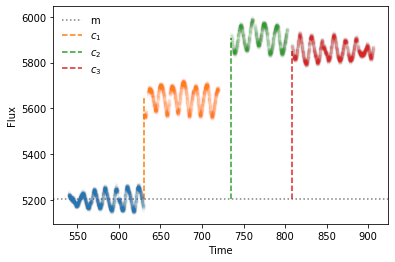

In [4]:
qs = sorted(np.unique(tab['quarter']))
means = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    plt.errorbar(t['time'],t['flux'], yerr=t['error'], marker='.', linestyle='None', alpha=0.01)
    meanflux = np.mean(t['flux'])
    cycle_map[q] = ind
    means.append(meanflux)
    if i == 0:
        plt.axhline(meanflux, label='m', color='grey', ls=":")
    else:

        vmin = means[0]
        vmax = meanflux
        
        print( t['time'][0])
        plt.plot((t['time'][0], t['time'][0]), (vmin, vmax), label=rf'$c_{i}$', color=f'C{i}', ls='--') 
    
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(frameon=False)


### As you can see there is some kind of periodic singal, but it's not perfectly regular. There is also the usual offsets between Kepler photometry in different cycles.

### You'll need four parameters to describe constants ($m, c_1, c_2, c_3$) to renormalize the flux to the first cycle, illustrated in the figure above. 
### $m$ specifies the mean of the Gaussian process, while $c_1, c_2, c_3$ are nuisance parameters. 

### You know how to implement a model with one common zeropoint and multiple offsets - this was what you did on your midterm.


### You'll also need some model to describe the quasi-periodic oscillations. There's no good way to write down a model in real for these in real space because stellar magnetic fields are incredibly complicated. 

### Instead we'll write down a model for the covariance between the observations and use a Gaussian process to model the star. You can model quasi-periodic correlation structure as something periodic + something that varies the periodicity smoothly:

## $$k(t_i, t_j) = A\cdot \exp\left(-\Gamma_1\cdot \sin^2\left(\frac{\pi}{P}|t_i - t_j|\right) -  \frac{|t_i-t_j|^2}{\lambda}) \right) $$

### This is another 4 parameters, ($A, \Gamma_1, P, \lambda$) parameters for a total of 8: ($m, c_1, c_2, c_3, A, \Gamma_1, P, \lambda$)


<hr>

### Q1: To implement the GP correlations, use the `george` package to construct this quasi-periodic kernel
https://george.readthedocs.io/en/latest/user/kernels/


### In particular, you should be able to combine `ExpSine2Kernel` and `ExpSquaredKernel` to get a model for the quasi-periodic oscillations.

In [5]:
def kernel(metric, A, gamma,P):
    k_sine = kernels.ExpSine2Kernel(gamma=gamma, log_period=P, bounds=None, ndim=1, axes=None) 
    k_exp = kernels.ExpSquaredKernel(metric=metric, lower=True, bounds=None, ndim=1, axes=None)
    k_combined = A * k_sine *k_exp
    return k_combined

#A, METRIC,GAMMA, LOG_P  = 1,1,1,4 #initial guesses

### Q2: To implement the full model, read how to use `george`'s modeling protocol:
https://george.readthedocs.io/en/latest/tutorials/model/

Text(0.5, 1.0, 'Model')

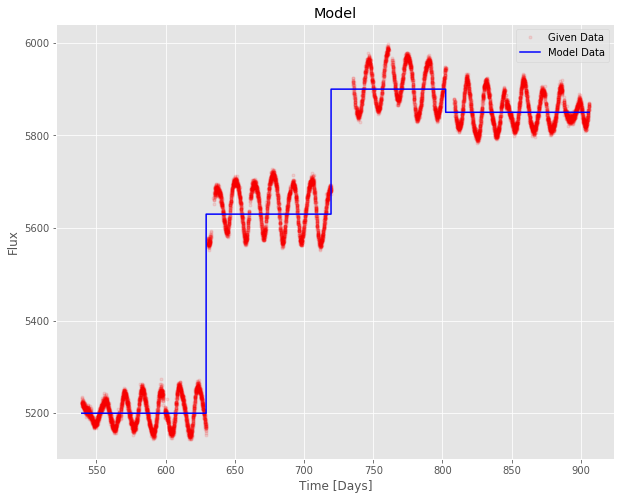

In [6]:
from george.modeling import Model

class Model(Model):
    parameter_names = ("m", "c1", "c2", "c3")
    
    #simple model that accounts for the offsets
    def get_value(self, t):
        #find the index ranges for each chunck of data and then add the ofset to each set to make model flux
        quarter = np.array(tab['quarter'])
        d = {}
        for i in range(len(quarter)):
            if quarter[i] not in d.keys():
                d[quarter[i]] = []
                d[quarter[i]].append(i)
            else:
                d[quarter[i]].append(i)

        model_flux = np.zeros(len(quarter))
        #accounting for the offset 
        model_flux[np.min(d[6]):np.max(d[6])] = self.m
        model_flux[np.max(d[6]):np.max(d[7])] = self.m + self.c1
        model_flux[np.max(d[7]):np.max(d[8])] = self.m + self.c2
        model_flux[np.max(d[8]):] = self.m + self.c3
        return model_flux
    


#guess values from graph
m_g,c1_g,c2_g, c3_g = 5200, 5630-5200 , 6300-5600,6950- 6300
model_flux = Model(m=m_g,c1=c1_g,c2=c2_g,c3=c3_g).get_value(tab['time'])

#plot the model on top of the original data  
plt.style.use("ggplot")
plt.figure(figsize=(10,8))
plt.plot(tab['time'],tab['flux'],'r.',alpha=.1,label='Given Data')
plt.plot(tab['time'],model_flux,'b-',label='Model Data')
plt.xlabel("Time [Days]")
plt.ylabel("Flux")
plt.legend(loc='best')
plt.title('Model')



In [7]:
def kernel(metric, A, gamma,P):
    k_sine = kernels.ExpSine2Kernel(gamma=gamma, log_period=P)#, bounds=None, ndim=1, axes=None) 
    k_exp = kernels.ExpSquaredKernel(metric=metric)#, lower=True, bounds=None, ndim=1, axes=None)
    k_combined = A * k_sine *k_exp
    return k_combined

In [8]:
# time = tab["time"][::20]
# flux = tab["flux"][::10]
# flux_err = tab["error"][::10]

[5.2e+03 4.3e+02 7.0e+02 6.5e+02 0.0e+00 1.0e+00 4.0e+00 0.0e+00]


Text(0.5, 1.0, 'GP Model, Simple Model, Given data')

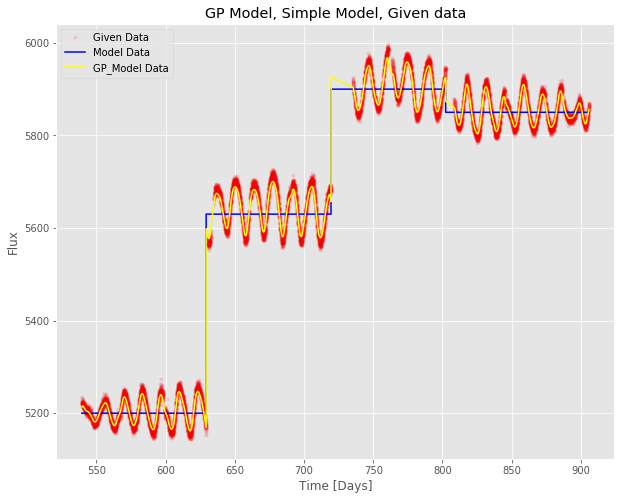

In [18]:
A, METRIC,GAMMA, LOG_P  = 1,1,1,4 #initial guesses
MEAN = Model(m=m_g,c1=c1_g,c2=c2_g,c3=c3_g)
k = kernel(metric = METRIC, A=A, gamma = GAMMA, P = LOG_P)
gp = george.GP(k, mean = Model(m=m_g,c1=c1_g,c2=c2_g,c3=c3_g))
gp.compute(tab["time"],tab["error"])

print(gp.get_parameter_vector())

mu,var = gp.predict(tab["flux"],tab["time"],return_var=True)


plt.style.use("ggplot")
plt.figure(figsize=(10,8))
plt.plot(tab['time'],tab['flux'],'r.',alpha=.1,label='Given Data')
plt.plot(tab['time'],model_flux,'b-',label='Model Data')
plt.plot(tab["time"], mu, color="yellow", label = 'GP_Model Data')
plt.fill_between(tab["time"], mu-np.sqrt(var), mu+np.sqrt(var), color='lightgrey')
plt.xlabel("Time [Days]")
plt.ylabel("Flux")
plt.legend(loc='best')
plt.title('GP Model, Simple Model, Given data')


In [19]:
print(gp.get_parameter_vector())

[5.2e+03 4.3e+02 7.0e+02 6.5e+02 0.0e+00 1.0e+00 4.0e+00 0.0e+00]


### Q3: With your model and likelihood constructured, write down priors on the parameters (you should be able to estimate from the plots)

In [20]:
from scipy.optimize import minimize

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(tab["flux"] ,quiet=True)
print("check1")
def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(tab["flux"])
print("check2")
p0 = gp.get_parameter_vector()
print("check3")
result = minimize(neg_ln_like, p0)#, jac=grad_neg_ln_like)
print("check4")

gp.set_parameter_vector(result.x)
print("A = ", result.x[0])
print("Metric = ", result.x[1])
print("Gamma = ", result.x[2])
print("Log_P = ", result.x[3])

check1
check2
check3


KeyboardInterrupt: 

### Q4: Use `emcee` to optimize the model parameters and hyper-parameters, **using only every 10th sample in time**
### (Don't go overboard with the number of walkers or steps)
https://george.readthedocs.io/en/latest/tutorials/hyper/ may help

In [ ]:
import emcee
import corner

def ln_like(p):
    gp.set_parameter_vector(p)
    return gp.log_likelihood(tab["flux"][::50],quiet=True)

param_vec = gp.get_parameter_vector()

# Set up the sampler.
nwalkers, ndim = 32, len(param_vec)
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_like)

# Initialize the walkers.
p0 = gp.get_parameter_vector() + 1e-4 * np.random.randn(nwalkers, ndim)

print("Running burn-in")
p0, _, _ = sampler.run_mcmc(p0, 200)
p0, lp, _ = sampler.run_mcmc(p0, 500)
burn1 = np.copy(sampler)

print("Running second burn-in...")
p0 = p0[np.argmax(lp)] + 1e-6 * np.random.randn(nwalkers, ndim)
sampler.reset() 

print("Running production chain")
sampler.run_mcmc(p0, 200);

p0, _, _ = sampler.run_mcmc(p0, 500)
burn2 = np.copy(sampler)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 1000)



In [ ]:
# print(sampler.get_chain())

In [ ]:
fig, axes = plt.subplots(nrows=ndim,figsize=(10,20), sharex=True)
samples = sampler.get_chain()
labels = ['m','c1','c2','c3','A','gamma','logP','lambda']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [ ]:
names = gp.get_parameter_names()
inds = np.array([names.index("mean:"+k) for k in ['m','c1','c2','c3']])
corner.corner(sampler.flatchain[:, inds], labels=['m','c1','c2','c3'],truths=res.x,quantiles=[0.16,0.50,0.84])
plt.suptitle('Fitting results for the mean function')


### Q5: Plot your posterior model over the data after correcting for the offsets, showing the points you used to condition the GP in red, and the remaining data in black. 